# Using Genestack Omics APIs for eQTL analysis

### 1. Connect to the instance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
# Genestack client library
import integration_curator

os.environ['PRED_SPOT_HOST'] = 'occam.genestack.com'
os.environ['PRED_SPOT_TOKEN'] = '<your API token>'

omics_api = integration_curator.OmicsQueriesApi()

### 2. Get samples

In [2]:
study_name = 'Test_1000G'
sample_field = 'Species or Strain'
sample_values = ['British', 'Finnish']
sample_filter = ' OR '.join(['"%s"="%s"' % (sample_field, sample_value) 
                             for sample_value in sample_values])

data = omics_api.search_samples(
    study_filter='genestack:name="%s"' % study_name, 
    sample_filter=sample_filter
)
# data
samples = pd.DataFrame.from_dict([item['metadata'] for item in data.data])
samples[['genestack:accession', sample_field]].head()

,genestack:accession,Species or Strain
0,GSF724749,British
1,GSF724750,British
2,GSF724751,Finnish
3,GSF724752,Finnish


### 3. Get expression data

In [3]:
gene = 'ENSG00000077044'

data = omics_api.search_expression_data(
    study_filter='genestack:name="%s"' % study_name,
    sample_filter=sample_filter,
    ex_query='Gene=%s MinValue=0.0' % gene
)
expressions = pd.DataFrame.from_dict({'genestack:accession': item['relationships']['sample'], 
                                      'expression': item['expression']} for item in data.data)
expressions.head()

,expression,genestack:accession
0,14.74187,GSF724749
1,16.84732,GSF724750
2,17.21227,GSF724751
3,19.51897,GSF724752


### 4. Get variation data

In [4]:
variant = 'rs838705'
data = omics_api.search_variant_data(
    study_filter='genestack:name="%s"' % study_name,
    sample_filter=sample_filter,
    vx_query='VariationId=%s' % variant
)
def normalise_genotype(gt): return '1|0' if gt == '0|1' else gt
genotypes = pd.DataFrame.from_dict({'genestack:accession': item['relationships']['sample'], 
                                      'genotype': normalise_genotype(item['genotype']['GT'])} 
                                   for item in data.data)
genotypes.head()

,genestack:accession,genotype
0,GSF724749,0|0
1,GSF724750,1|0
2,GSF724751,1|0
3,GSF724752,1|1


### 5. eQTL plot

Text(0.5,0,'Genotype')

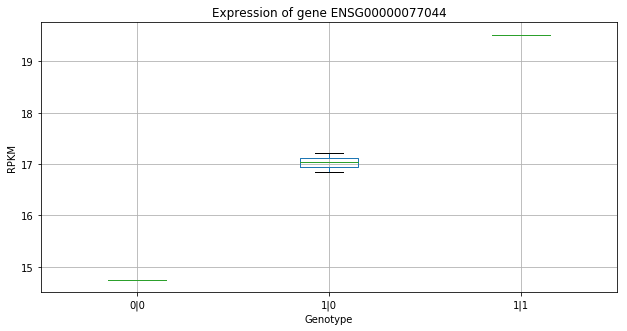

In [5]:
combined_data = pd.merge(samples, pd.merge(genotypes, expressions))
combined_data.boxplot('expression', 'genotype', rot=0, figsize=(10,5))
plt.suptitle('')
plt.title('Expression of gene %s' % gene)
plt.ylabel('RPKM')
plt.xlabel('Genotype')